# Import

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms.functional as TF

import PIL
from collections import OrderedDict
from tqdm.auto import tqdm
import os
import json
import requests
from io import BytesIO

from dataset import ImageCoco, Collate_coco
import config
from model import ImageCaptioningModel
from train_val_model import train


from utils import SaveBestModel, EarlyStopping, LrScheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at ./pre_trained_models/gpt2 and are newly initialized: ['h.0.crossattention.c_proj.weight', 'h.11.crossattention.c_attn.weight', 'h.2.ln_cross_attn.weight', 'h.5.crossattention.bias', 'h.2.crossattention.q_attn.weight', 'h.7.crossattention.bias', 'h.4.crossattention.q_attn.weight', 'h.4.ln_cross_attn.weight', 'h.9.crossattention.q_attn.weight', 'h.11.crossattention.bias', 'h.7.crossattention.q_attn.weight', 'h.11.crossattention.c_proj.weight', 'h.6.crossattention.q_attn.weight', 'h.3.crossattention.bias', 'h.3.crossattention.masked_bias', 'h.1.ln_cross_attn.weight', 'h.6.ln_cross_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.9.ln_cross_attn.weight', 'h.8.crossattention.c_proj.bias', 'h.11.crossattention.masked_bias', 'h.5.crossattention.c_attn.weight', 'h.10.ln_cross_attn.weight', 'h.6

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose(
    [   
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [3]:
train_dataset = ImageCoco(root_directory='E:/data/coco2014/train2014/', 
                    annFile='E:/data/coco2014/annotations/captions_train2014.json', 
                    tokenizer=config.TOKENIZER,
                    transform=transform_train,
                    split_ratio=0.01)

val_dataset = ImageCoco(root_directory='E:/data/coco2014/val2014/', 
                    annFile='E:/data/coco2014/annotations/captions_val2014.json', 
                    tokenizer=config.TOKENIZER,
                    transform=transform_val,
                    split_ratio=0.01)

In [4]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              shuffle=True,
                              num_workers=8, 
                              pin_memory=True,
                              batch_size=config.TRAIN_BATCH_SIZE, 
                              collate_fn=Collate_coco(config.TOKENIZER.pad_token_id, 
                                                   config.TOKENIZER, 
                                                   max_len=config.MAX_LEN))


test_dataloader = DataLoader(dataset=val_dataset, 
                             shuffle=True, 
                             num_workers=8, 
                             pin_memory=True,
                             batch_size=config.VALID_BATCH_SIZE, 
                             collate_fn=Collate_coco(config.TOKENIZER.pad_token_id, 
                                                  config.TOKENIZER, 
                                                  max_len=config.MAX_LEN)
                            )

In [5]:
# images, sents, attention = next(iter(test_dataloader))

In [6]:
# images.shape, sents[0], attention.shape

# Init Model

In [5]:
target_vocab_len = len(config.TOKENIZER)
model = ImageCaptioningModel(target_vocab_len, 
                             embedding_size=768,  
                             num_layers=config.NUM_LAYERS, 
                             heads=config.NUM_HEADS, 
                             dropout=config.DECODER_DROPOUT, 
                             feedforward_dim=3072, 
                             max_len=config.MAX_LEN).to(config.DEVICE)

print(f"Model paramters here : {sum(p.numel() for p in model.parameters())}")
pad_idx = config.TOKENIZER.pad_token_id

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-6, amsgrad=True)

d:\anaconda\coda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\coda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model paramters here : 196881216


# Load model

In [6]:
optimizer.load_state_dict(torch.load("./saved_models/training-2023-05-18-03-38-13_RESNET+GPT2/bestmodel.bin",map_location=config.DEVICE)["optimizer_state_dict"])
model.load_state_dict(torch.load("./saved_models/training-2023-05-18-03-38-13_RESNET+GPT2/bestmodel.bin",map_location=config.DEVICE)["model_state_dict"])
# optimizer.param_groups[0]['lr'] = config.LEARNING_RATE

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# Training

In [ ]:
model, train_loss, val_loss = train(model,
                                          train_dataloader,
                                          test_dataloader, 
                                          config.EPOCHS,
                                          config.LEARNING_RATE, 
                                          loss_fn,
                                          optimizer=optimizer,
                                          early_stop=True)

# Caption Image

In [18]:
import torch
import PIL
import numpy
import requests
from io import BytesIO 
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

def caption_image(model, image_link, max_len=100):
    model.eval()
    with torch.no_grad():
        if image_link.startswith('http'):
            res = requests.get(image_link)
            img = PIL.Image.open(BytesIO(res.content))
        else:
            img = PIL.Image.open(image_link).convert()

        encoder_input = transform_val(img)

        encoder_input = encoder_input.unsqueeze(0).to(device)
        encoder_output = model.image_encoder(encoder_input).unsqueeze(1).to(device)
        tgt_tokens = torch.ones(1, 1 ).fill_(config.TOKENIZER.bos_token_id).type(torch.long).to(device)

        for i in range(max_len - 1):
            tgt_mask = model.generate_square_subsequent_mask(tgt_tokens.size(1))
            tgt_attentions = torch.ones_like(tgt_tokens).to(device)
            out = model.decoder(input_ids=tgt_tokens, 
                                encoder_hidden_states=encoder_output, 
                                attention_mask=tgt_attentions)['logits']

            next_word = torch.argmax(out[:,-1,:], dim=-1)
            next_word = next_word.item()
            if next_word == config.TOKENIZER.eos_token_id:
                break
            decoder_input_masked = torch.ones(1,1).type_as(tgt_tokens.data).fill_(next_word).to(device)
            tgt_tokens = torch.cat((tgt_tokens, decoder_input_masked), dim=1)

        decoded_sentence =  config.TOKENIZER.decode(tgt_tokens[0])
        cap = decoded_sentence.replace(config.TOKENIZER.bos_token, '').capitalize()

        plt.imshow(img)
        return cap


# Test

'A dog is in a cage with some hay.'

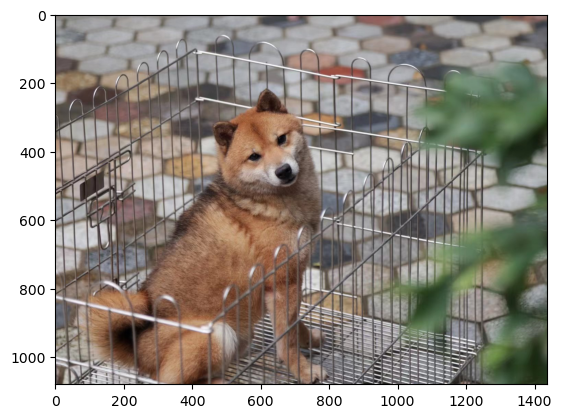

In [10]:
caption_image(model, "./test_image/1.jpg")

'A woman sitting at a desk with a laptop computer.'

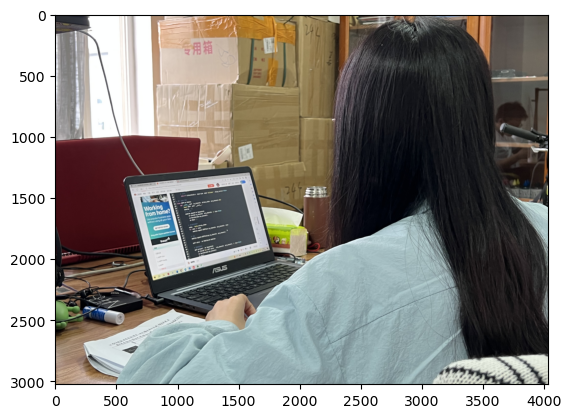

In [12]:
caption_image(model, "./test_image/3.jpg")

'A man in a suit and tie standing in front of a table.'

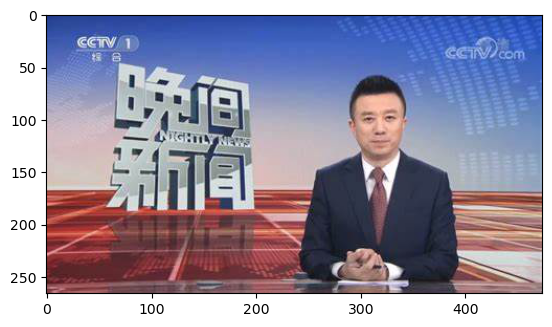

In [19]:
caption_image(model, "./test_image/7.jpg")